In [157]:
import os
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy.ndimage import gaussian_filter, convolve
from sklearn.metrics import classification_report
import cv2

color_map = 'gray'
gauss_sigma = [1.1,1.3,1.4,1.5,1.7]
thresholds = [0.5,0.25,0.125,0.08]

In [392]:
# For every input image we
# 1. gaussian blur for every gauss_sigma, store in key=(index, blur_strength)
# 2. convolve with laplacian kernel on every new image.
# 3. threshold every image with range of th's
# Returns dictionary where its values is a list of images
def apply_laplacian(images, thresholds, sigmas):
    num_imgs = len(images)
    img_map = dict()
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])
    for i, image in enumerate(images):
        for s in sigmas:
            img_map[i, s] = convolve(gaussian_filter(image, sigma=s),kernel)
        if i==0: plt.imshow(img_map[i,1.1], cmap=color_map)
        print(int(i/num_imgs*100),"%", end="\r")
    print("100%")
    num_imgs = len(img_map.values())

    for i,key in enumerate(img_map.keys()):
        img_map[key] = [np.where(img_map[key] >= np.max(img_map[key])*t, np.max(img_map[key]),0) for t in thresholds]
        print(int(i/num_imgs*100),"%", end="\r")
    print("100%")

    print("complete")
    return img_map

def getDirImages(directory):
    images = list()
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            if os.path.isfile(path):
                image = PIL.Image.open(path).convert('L')
                # image = color.rgb2gray(image)
                images.append(image)
    return images

def display_image_list(images, thresholds,gauss_sigmas ):
    rows,cols = len(gauss_sigmas), len(thresholds)
    print(rows,cols)
    fig = plt.figure(figsize=(cols*1.5,1.5*rows*1.05), dpi=600)
    i = 1
    for key in images.keys():
        if i <= 20:
            for img in images[key]:
                fig.add_subplot(rows,cols,i)
                plt.imshow(img, cmap=color_map)
                i+=1

    # The below does not do any logic, it is simply labelling the rows/cols for easier understanding.
    # There is no need to try to understand this stuff. It looks pretty bad... There is a plt.tight_layout() and plt.show() at the bottom
    for e, ax in enumerate(fig.get_axes()):
        ax.set_axis_off()
        if e == e % cols:
            ax.annotate(str(thresholds[e]*100)+"%",
                xy=(0.5, 1),
                xytext=(0, 2.5),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline")
        if e%cols==0:
            h = "gauss:" + str((gauss_sigmas)[int(e/cols)])
            ax.annotate(h,
                xy=(0, 0),
                xytext=(0, 0),
                textcoords="offset points",
                ha="right",
                va="top",
                rotation= 90
            )
    plt.tight_layout()
    plt.show()

def getPrecision255Score(rep):
    new_report = list()
    for i,c in enumerate(rep):
        if rep[i]==' ' and rep[i-1]==' ':  # Skip empty spaces
            continue
        if c.isnumeric() or c==' ' or c=='.':
            new_report.append(c)

    out = ''.join(new_report)
    return float(out.split(' ')[11])

80
100%
100%
complete


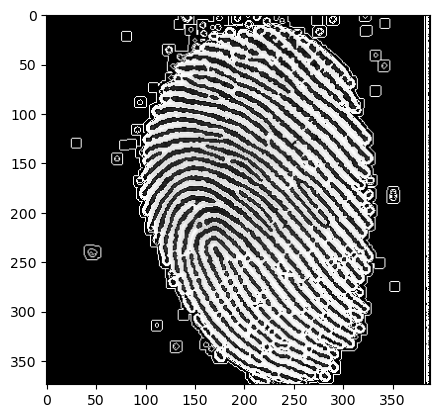

In [391]:
root = 'C:\\Users\\lukas\\OneDrive\\Desktop\\Programming\\PycharmProjects\\EdgeDetectionPaper\\'
fingerprints1 = root + 'images\\fingerprints\\DB1_B'
leaves = root + 'images\\Leaves\\Leaf'
test = root + 'images\\test'

image_list = getDirImages(fingerprints1)
ground_truth_original = np.uint8(image_list[0])

image_list = apply_laplacian(image_list, thresholds, gauss_sigma)

# Display All images

5 4


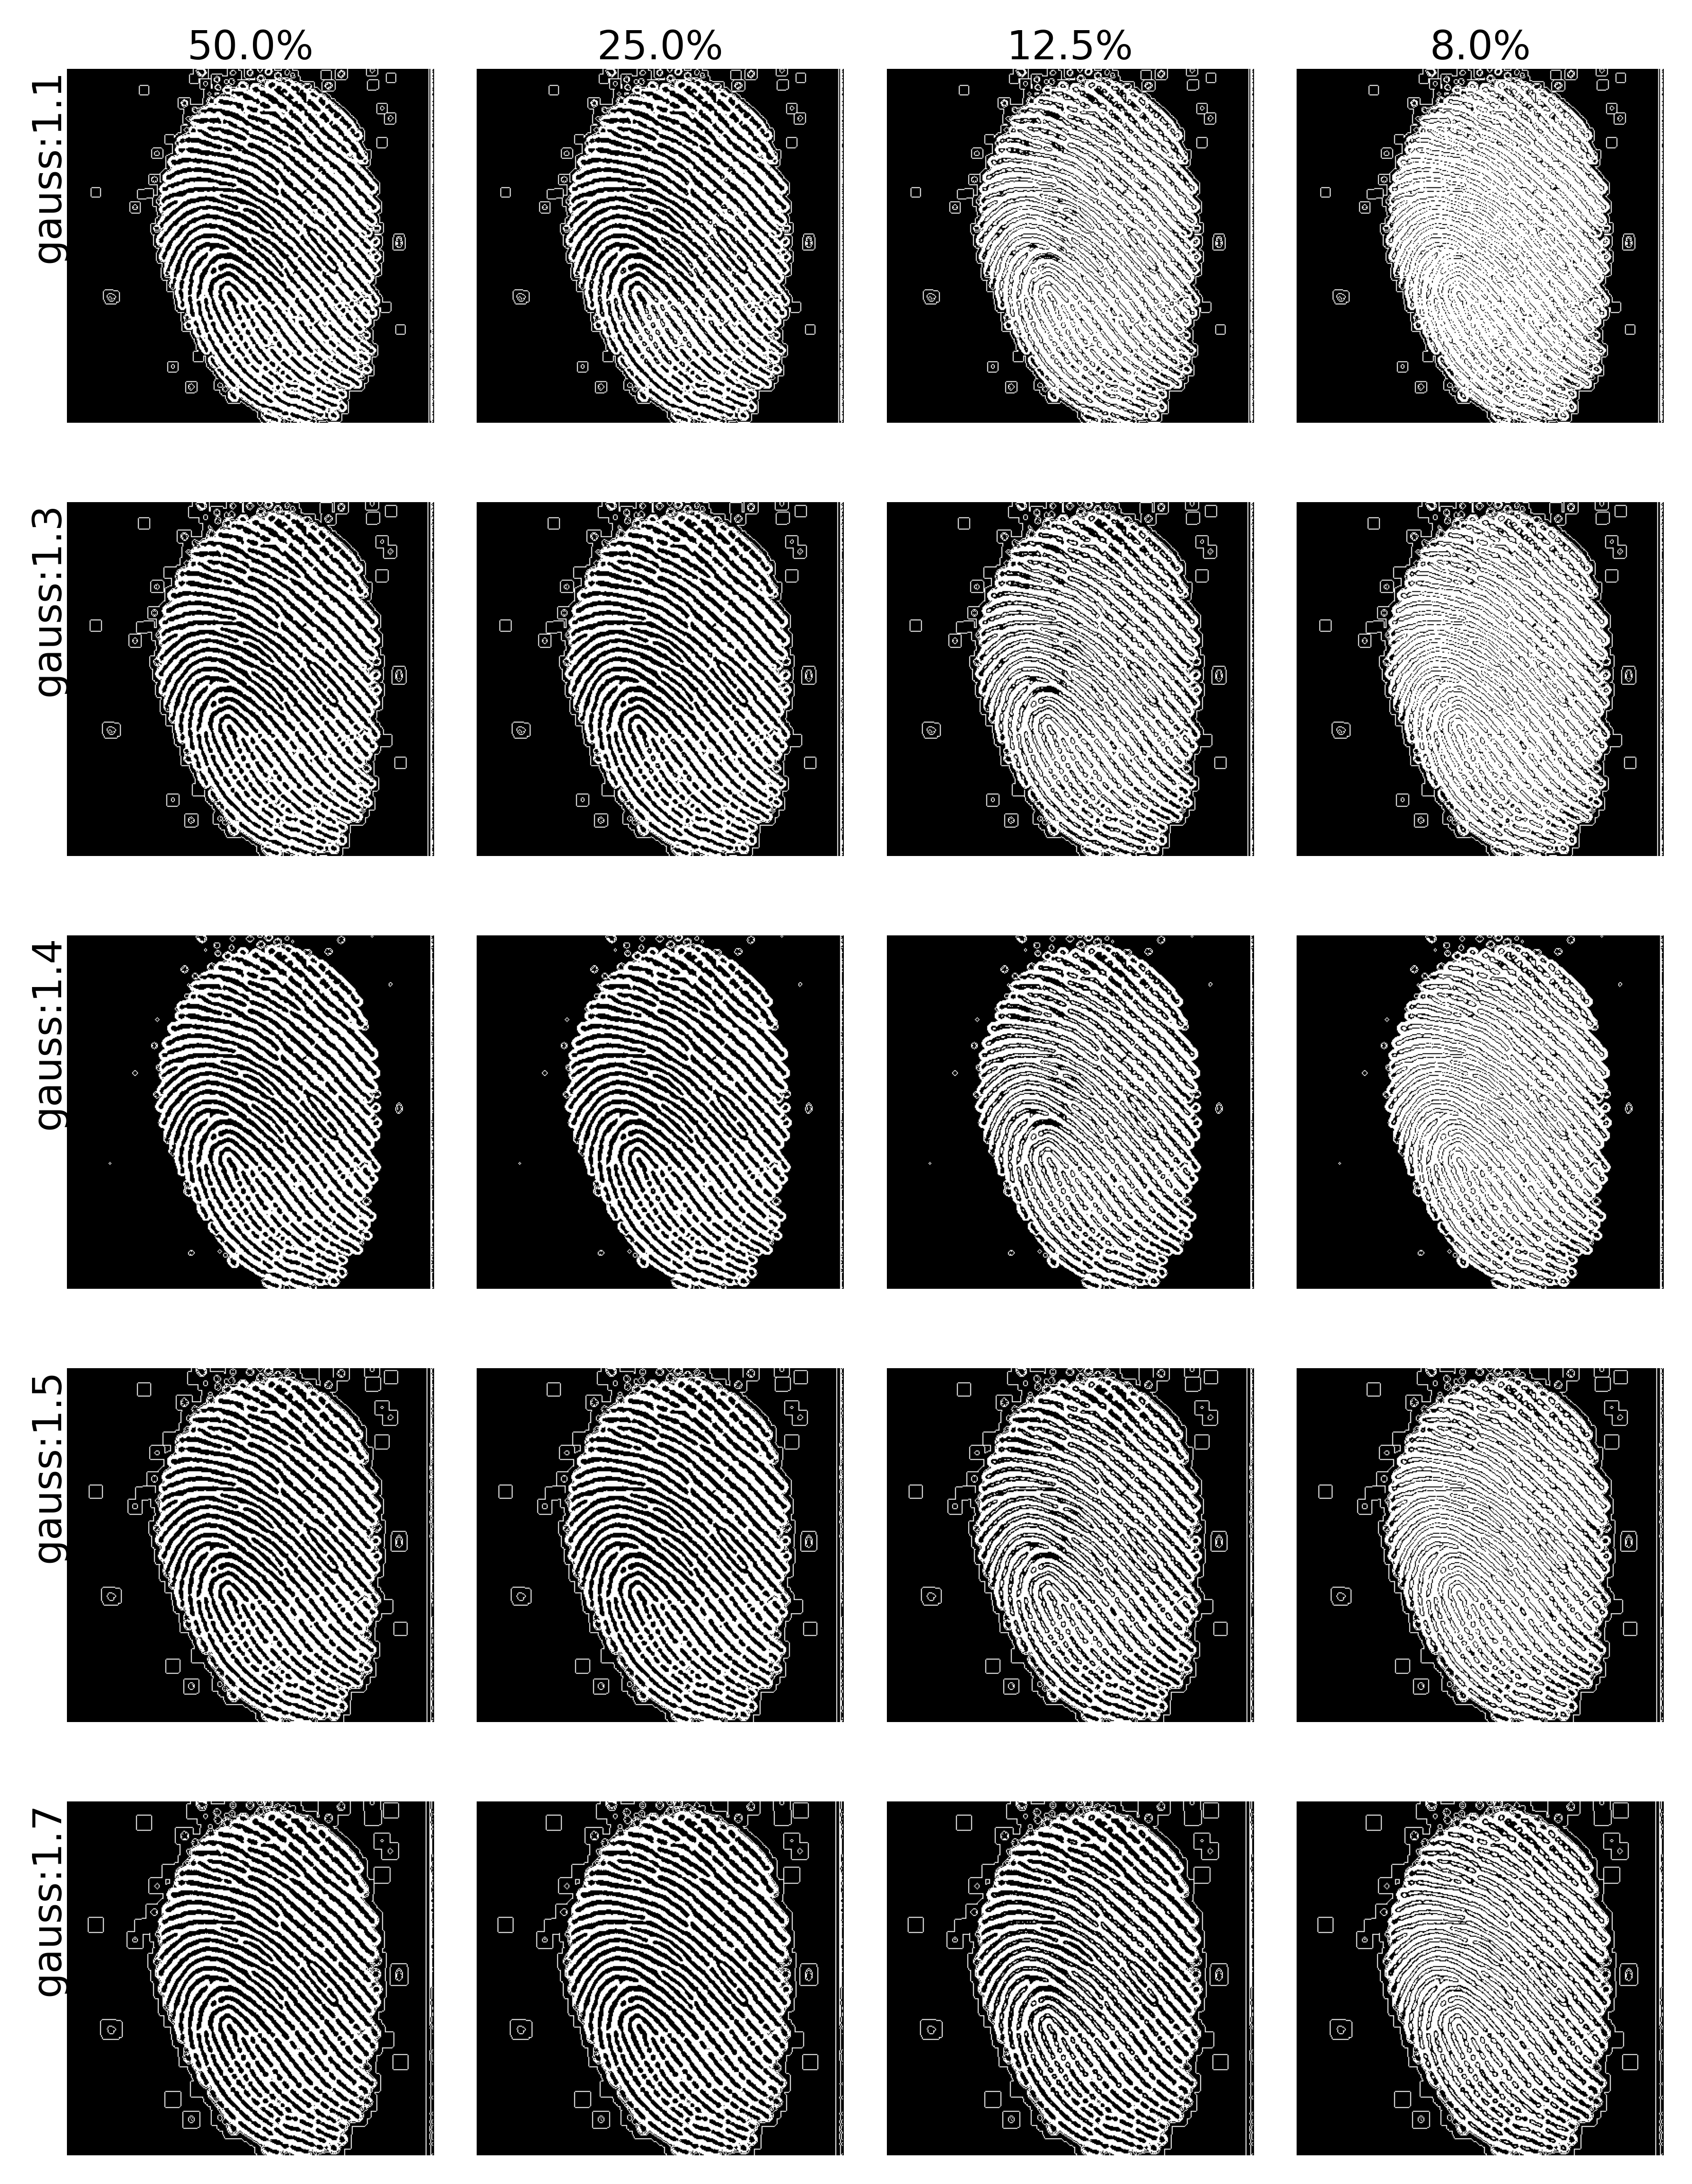

In [393]:
display_image_list(image_list, thresholds,gauss_sigma)

# Ascertain ground-truth with CV2's Canny Edge Detection Algorithm.
Store as 1d array

In [190]:
ground_truth = cv2.Canny(ground_truth_original, 120, 150)
flattened_ground_truth = ground_truth.flatten()

In [330]:
maxPrecision = 0
for key in image_list.keys():
    for img in image_list[key]:
        precisionFor255 = getPrecision255Score(classification_report(flattened_ground_truth, img.flatten()))
        print(precisionFor255, end="\r")
        maxPrecision = precisionFor255 if precisionFor255>maxPrecision else maxPrecision


print("max: ",maxPrecision)

max:  0.15


In [302]:
# print("Precision for 255's is -", float(report_values[11])*100,"%")

Precision for 255's is - 13.0 %


In [294]:
# print("Precision for 0's", report_values[6])
# print("Recall for 0's", report_values[7])
# print("F1 for 0's", report_values[8])
#
# print("Precision for 255's", report_values[11])
# print("Recall for 255's", report_values[12])
# print("F1 for 255's", report_values[13])

Precision for 0's 0.89
Recall for 0's 0.69
F1 for 0's 0.78
Precision for 255's 0.13
Recall for 255's 0.36
F1 for 255's 0.19


In [303]:
# print(rep)  # Full classification report

              precision    recall  f1-score   support

           0       0.89      0.69      0.78    128714
         255       0.13      0.36      0.19     16398

    accuracy                           0.66    145112
   macro avg       0.51      0.53      0.49    145112
weighted avg       0.81      0.66      0.71    145112



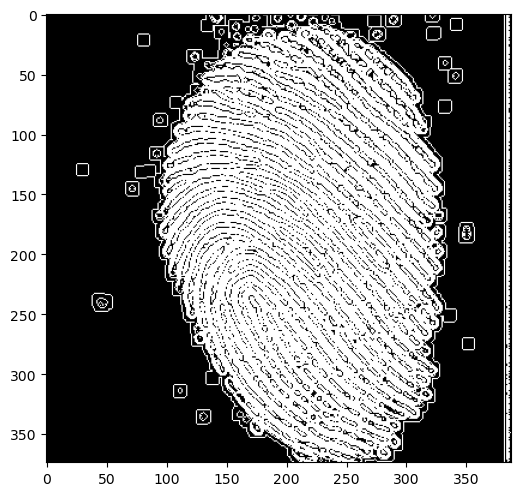

In [386]:
fig = plt.figure(figsize=(6,6), dpi=100)
plt.imshow(image_list[0, gauss_sigma[0]][3], cmap=color_map)
plt.show()

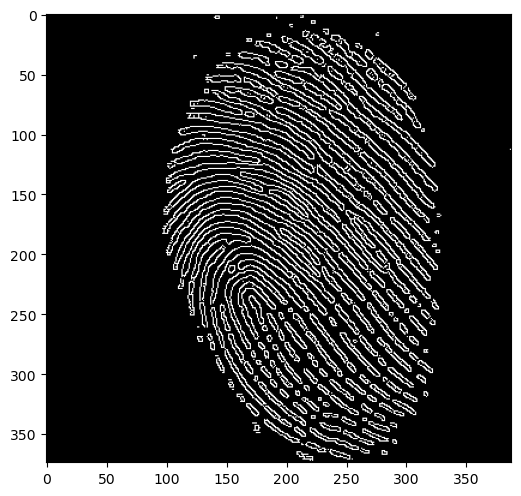

In [383]:
fig = plt.figure(figsize=(6,6), dpi=100)
plt.imshow(ground_truth, cmap=color_map)
plt.show()